## Applied - Question 10

This question will use a simulated dataset. We will explore the test error vs training 
error when number of features increase.

#### Import block

In [104]:
from operator import itemgetter
import numpy as np
import random
import pandas as pd
import scipy as sp
from itertools import combinations

import sklearn.linear_model as skl_lm
from sklearn.metrics import mean_squared_error
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import LeaveOneOut, KFold, cross_val_score, train_test_split
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA

import statsmodels.formula.api as smf
import statsmodels.api as sm

import matplotlib.pyplot as plt
import seaborn as sns

from forward_select import forward_select

%matplotlib inline
plt.style.use('seaborn-white')

#### (a) Generate data

In [105]:
# set seed
np.random.seed(1)

# Random x, y, eps
p = 20
n = 1000
X = np.random.randn(n, p)
B = np.random.rand(p)
eps = np.random.rand(n)

# Some B are 0
for i in [8,17,9,6,12]:
    B[i] = 0

# Naming X
name = []
for i in range(1, 21):
    name.append(f'X_{i}')

# Create y
y =  np.dot(X, B) + eps

# Finalize
X = pd.DataFrame(X, columns=name)
X.head()

,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,X_10,X_11,X_12,X_13,X_14,X_15,X_16,X_17,X_18,X_19,X_20
0,1.624345,-0.611756,-0.528172,-1.072969,0.865408,-2.301539,1.744812,-0.761207,0.319039,-0.249370,1.462108,-2.060141,-0.322417,-0.384054,1.133769,-1.099891,-0.172428,-0.877858,0.042214,0.582815
1,-1.100619,1.144724,0.901591,0.502494,0.900856,-0.683728,-0.122890,-0.935769,-0.267888,0.530355,-0.691661,-0.396754,-0.687173,-0.845206,-0.671246,-0.012665,-1.117310,0.234416,1.659802,0.742044
2,-0.191836,-0.887629,-0.747158,1.692455,0.050808,-0.636996,0.190915,2.100255,0.120159,0.617203,0.300170,-0.352250,-1.142518,-0.349343,-0.208894,0.586623,0.838983,0.931102,0.285587,0.885141
3,-0.754398,1.252868,0.512930,-0.298093,0.488518,-0.075572,1.131629,1.519817,2.185575,-1.396496,-1.444114,-0.504466,0.160037,0.876169,0.315635,-2.022201,-0.306204,0.827975,0.230095,0.762011
4,-0.222328,-0.200758,0.186561,0.410052,0.198300,0.119009,-0.670662,0.377564,0.121821,1.129484,1.198918,0.185156,-0.375285,-0.638730,0.423494,0.077340,-0.343854,0.043597,-0.620001,0.698032


#### (b) Splitting into train and test set

In [106]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, 
                                                    random_state=1)

#### (c) Best subset selection/Forward

Best subset will take a long time with p=20. Thus, I will use forward selection instead.

In [107]:
forward_df = forward_select(y_train, X_train, k=p)

d:\pycharmprojects\islr\venv\lib\site-packages\numpy\core\fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


Text(0.5, 1.0, 'MSE of training data')

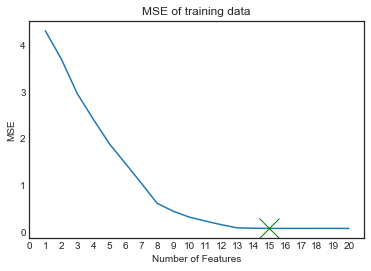

In [108]:
# Get MSE
mse_train = forward_df.RSS / n

# Minimum point
mse_train_min_index, mse_train_min = min(enumerate(mse_train), key=itemgetter(1))

# Plot MSE
plt.plot(forward_df.num_features, mse_train)
plt.plot(mse_train_min_index, mse_train_min, color='g', marker='x', markersize=20)
plt.xlabel('Number of Features')
plt.ylabel('MSE')
plt.xticks(np.arange(0, 21, 1))
plt.title('MSE of training data')

#### (d) Plotting test MSE

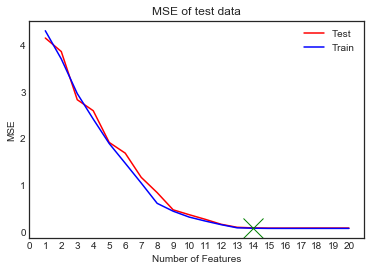

In [109]:
mse_test = []

# Loop through each model in forward selection and get MSE
for i in forward_df.features:
    regr = skl_lm.LinearRegression().fit(X_train[i], y_train)
    y_pred = regr.predict(X_test[i])
    mse = mean_squared_error(y_test, y_pred)
    mse_test.append(mse)
    
# Minimum point
mse_test_min_index, mse_test_min = min(enumerate(mse_test), key=itemgetter(1))

# Plot Test MSE
plt.plot(forward_df.num_features, mse_test, color='r', label='Test')
plt.plot(forward_df.num_features, mse_train, color='b', label='Train')
plt.plot(mse_test_min_index, mse_test_min, color='g', marker='x', markersize=20)
plt.xlabel('Number of Features')
plt.ylabel('MSE')
plt.xticks(np.arange(0, 21, 1))
plt.title('MSE of test data')
plt.legend()

#### (e) Best model

Luckily for us the best model with the lowest MSE on test data contains only 14
features. 

#### (f) Best model vs True model 

We employ the statsmodel since they gives a better tables!
The result is promising. All the 0 betas are either near 0 or omit. The coefficients 
estimates are very close to the true model.  

In [110]:
# Sort variables in best model to compare to our true data
temp = forward_df.features[15]
temp = sorted(temp, key=lambda line: int(line.split('_')[1]))

# coefficients
regr = sm.OLS(y, sm.add_constant(X[temp])).fit()
print(regr.summary().tables[1])

# True model
print(pd.Series(B, index=X.columns))

                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4913      0.009     52.203      0.000       0.473       0.510
X_1            0.4825      0.009     51.660      0.000       0.464       0.501
X_2            0.2995      0.009     32.077      0.000       0.281       0.318
X_3            0.3976      0.009     42.919      0.000       0.379       0.416
X_4            0.0991      0.010     10.220      0.000       0.080       0.118
X_5            0.7084      0.009     75.398      0.000       0.690       0.727
X_6            0.7068      0.009     74.618      0.000       0.688       0.725
X_8            0.0663      0.010      6.812      0.000       0.047       0.085
X_11           0.6933      0.009     75.263      0.000       0.675       0.711
X_12           0.2627      0.009     28.268      0.000       0.244       0.281
X_14           0.9264      0.009    100.284      0.0

d:\pycharmprojects\islr\venv\lib\site-packages\numpy\core\fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


#### (g) Plotting coefficients root square error

It is a bit tricky to understand the formula. Seperate out when r < j and r > j. 
Remember j goes from 1 to 20 ALWAYS while r goes 1 to 20 ITERATIVELY:
1. When r > j, set b_j_r = b_j_r
2. when r < j, set b_j_r = 0

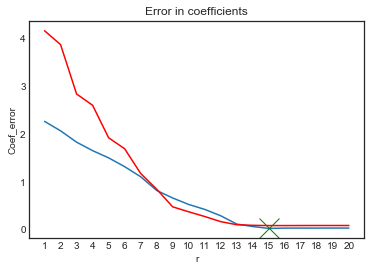

In [111]:
# create B dict for easy calling
B_dict = {i:j for i,j in zip(name, B)}

# Parameters for plot
coef_err = []

# Loop through each i in p
for i in range(0, 20):
    # Sort variables for easy interpretation
    temp = forward_df.features[i]
    temp = sorted(temp, key=lambda line: int(line.split('_')[1]))
    
    # Run regression with best model using i features
    regr = skl_lm.LinearRegression().fit(X[temp], y)
    
    # Coefficients name when r < j
    coef_left = list(set(name) - set(temp))
    
    # Coefficients when r < j and  r > j:
    b_j_in = [B_dict.get(key) for key in temp]   
    b_j_out = [B_dict.get(key) for key in coef_left]
    
    # Calculate the RS_coef_error
    err = np.sqrt(np.sum((b_j_in - regr.coef_)**2) +  # r > j
                  np.sum(np.array(b_j_out)**2))  # r < j, set b_r_j = 0
    coef_err.append(err)

# Get min
coef_err_min_index, coef_err_min = min(enumerate(coef_err), key=itemgetter(1))

# Plot 
plt.plot(range(1, 21), coef_err)
plt.plot(coef_err_min_index+1, coef_err_min, color='g', marker='x', markersize=20)
plt.xticks(np.arange(1, 21, 1))
plt.xlabel('r')
plt.ylabel('Coef_error')
plt.title('Error in coefficients')

# add comparison test MSE
plt.plot(forward_df.num_features, mse_test, color='r', label='Test')

